In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8, 10,  4,  3,  0,  6,  9,  1,  7]), tensor([2, 5]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[2.1859],
        [1.9117]], grad_fn=<AddmmBackward>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.2948]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.4701], requires_grad=True)

In [9]:
x = torch.ones(1)
linear_model(x)

tensor([0.7649], grad_fn=<AddBackward0>)

In [10]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.7649],
        [0.7649],
        [0.7649],
        [0.7649],
        [0.7649],
        [0.7649],
        [0.7649],
        [0.7649],
        [0.7649],
        [0.7649]], grad_fn=<AddmmBackward>)

In [11]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [12]:
linear_model.parameters()

<generator object Module.parameters at 0x7ff91064ead0>

In [13]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.6832]], requires_grad=True),
 Parameter containing:
 tensor([0.4065], requires_grad=True)]

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [15]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 187.5926, Validation loss 134.7720
Epoch 1000, Training loss 3.9201, Validation loss 1.4681
Epoch 2000, Training loss 3.3593, Validation loss 1.0955
Epoch 3000, Training loss 3.3497, Validation loss 1.0534

Parameter containing:
tensor([[5.3263]], requires_grad=True)
Parameter containing:
tensor([-17.1011], requires_grad=True)


In [16]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 109.3063, Validation loss 62.5220
Epoch 1000, Training loss 3.9496, Validation loss 1.4804
Epoch 2000, Training loss 3.3598, Validation loss 1.0968
Epoch 3000, Training loss 3.3497, Validation loss 1.0535

Parameter containing:
tensor([[5.3261]], requires_grad=True)
Parameter containing:
tensor([-17.1001], requires_grad=True)


In [17]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [18]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [20]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [21]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [22]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2889], requires_grad=True)

In [23]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 183.7548, Validation loss 130.0068
Epoch 1000, Training loss 5.0861, Validation loss 0.6607
Epoch 2000, Training loss 3.6614, Validation loss 5.3335
Epoch 3000, Training loss 2.2966, Validation loss 3.9053
Epoch 4000, Training loss 1.9445, Validation loss 3.0864
Epoch 5000, Training loss 1.8723, Validation loss 2.9373
output tensor([[13.2702],
        [ 7.5110]], grad_fn=<AddmmBackward>)
answer tensor([[15.],
        [ 8.]])
hidden tensor([[ 3.4784e-01],
        [ 3.1806e-01],
        [-1.1117e-03],
        [-3.8710e+00],
        [ 6.7909e+00],
        [-6.8947e+00],
        [ 3.0838e-01],
        [-7.9634e+00]])


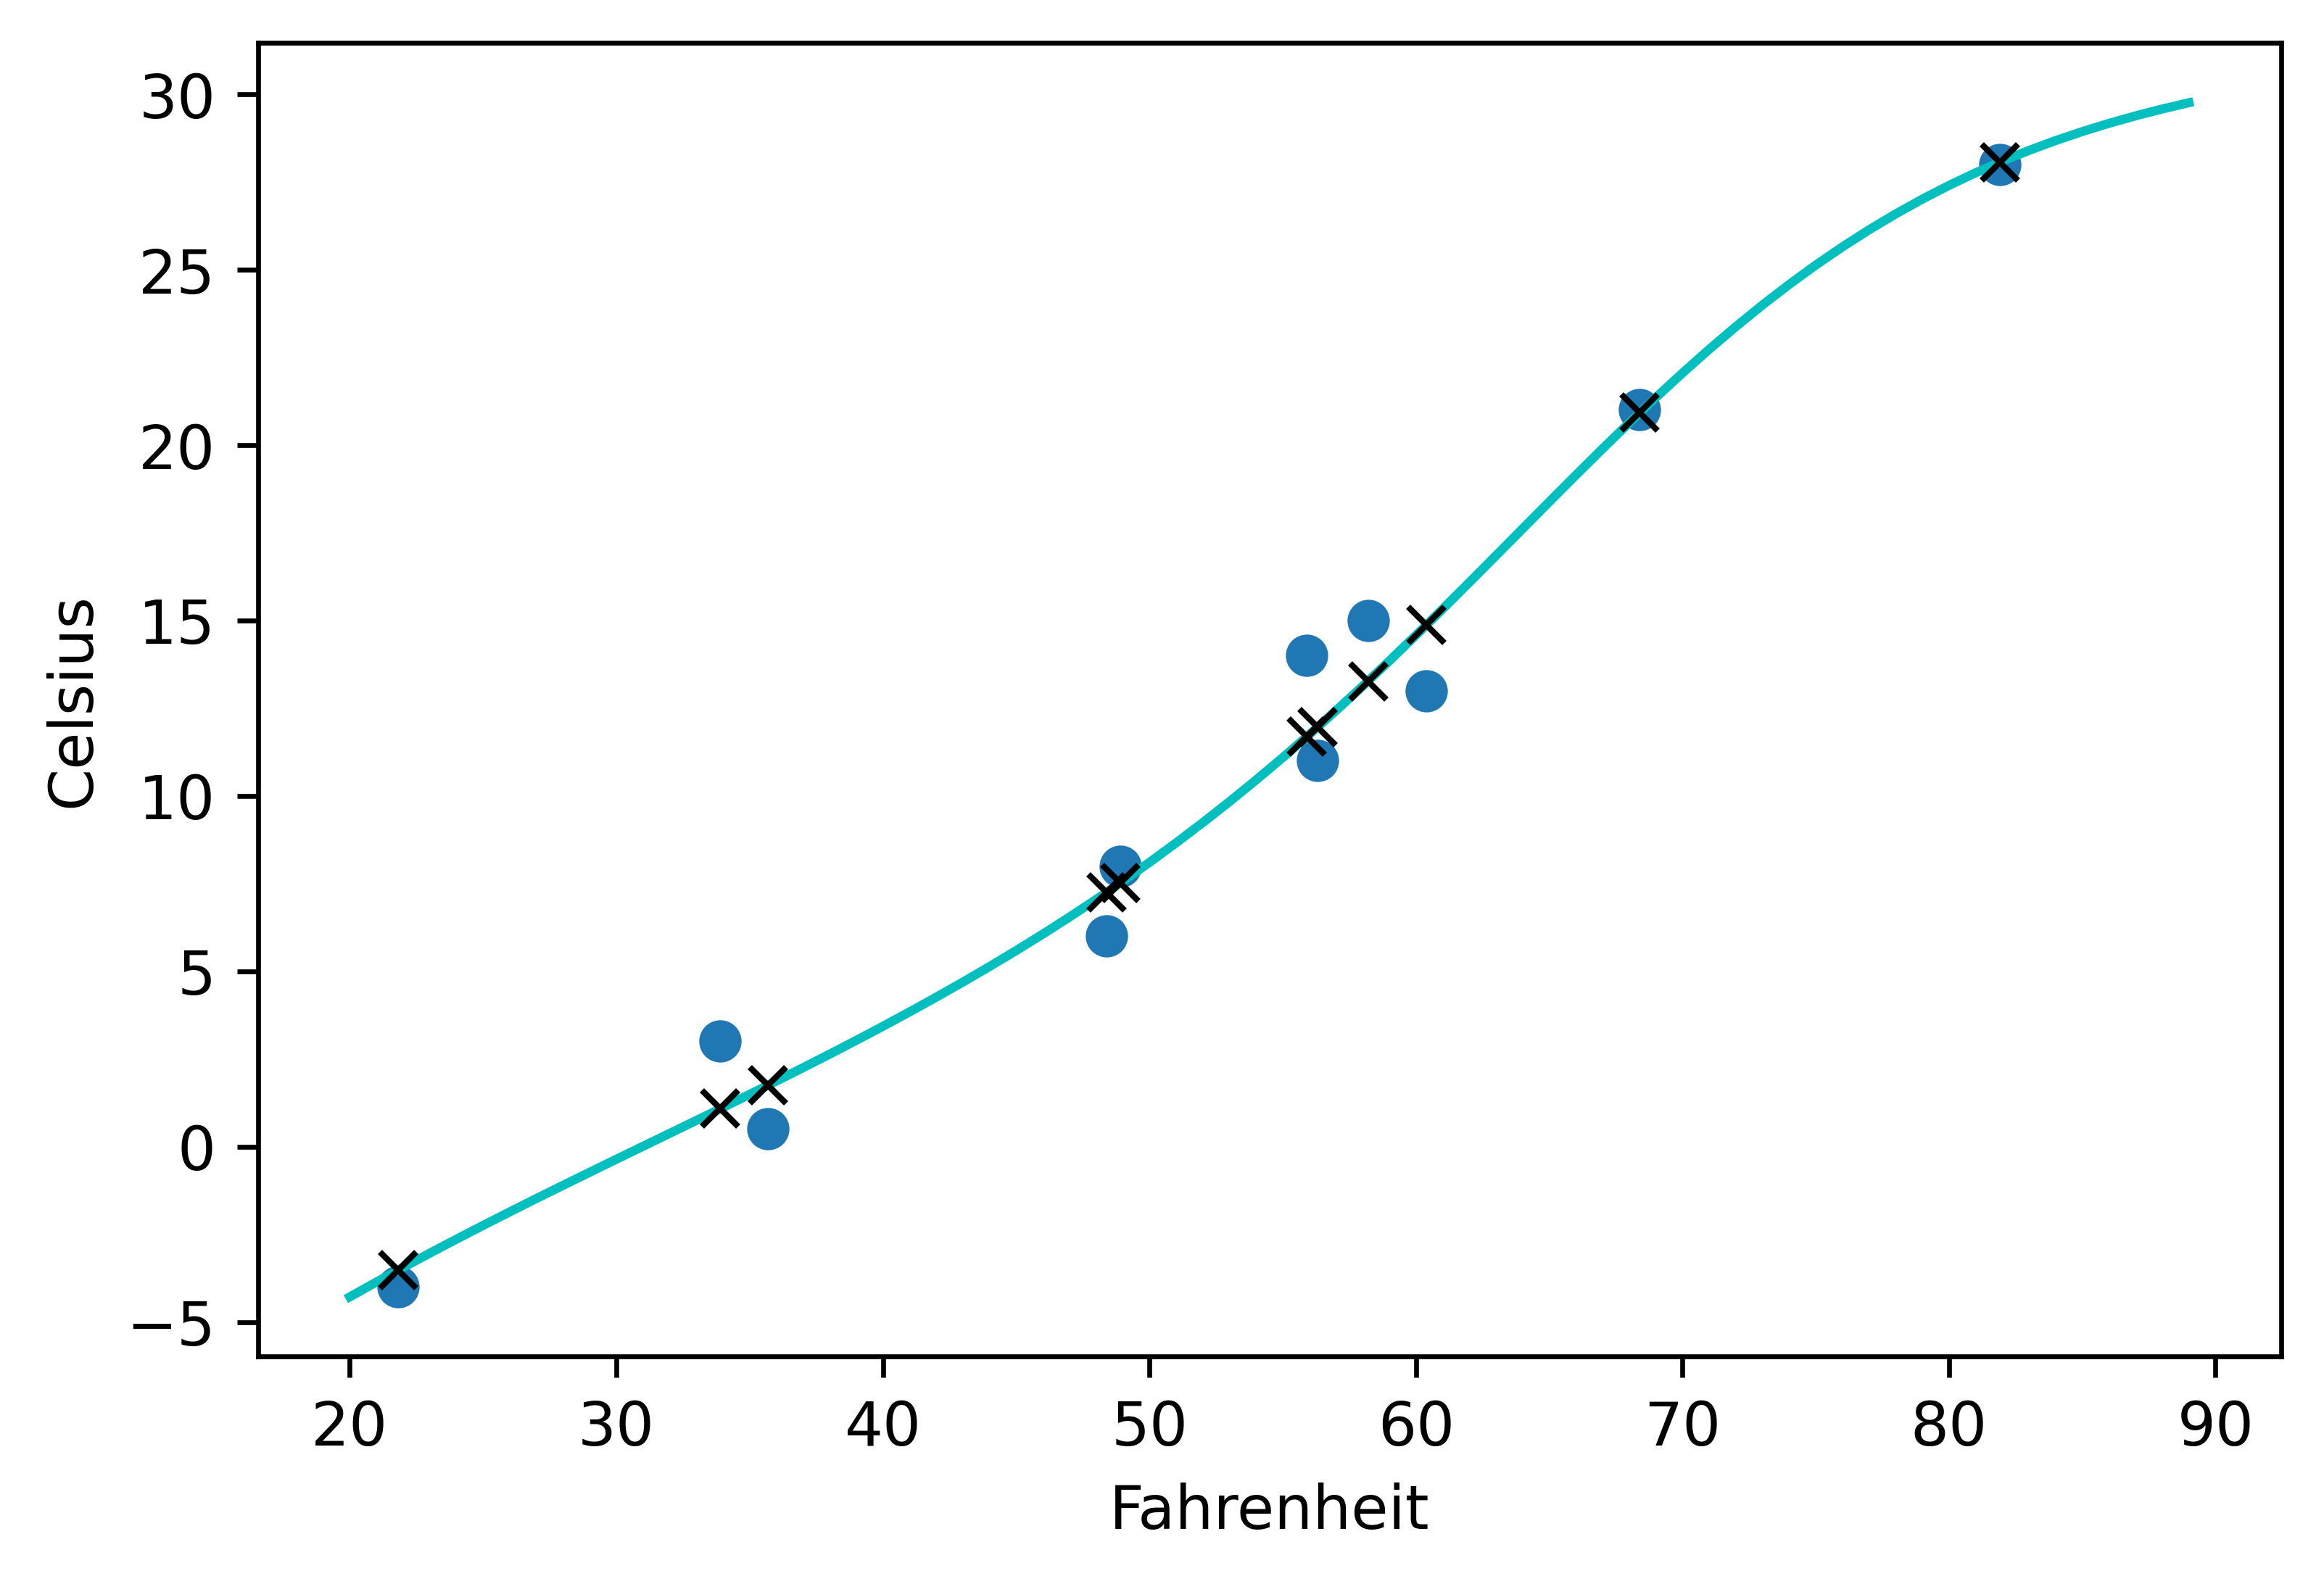

In [24]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 200.0715, Validation loss 148.0190
Epoch 1000, Training loss 60.1300, Validation loss 10.1292
Epoch 2000, Training loss 34.9257, Validation loss 6.0248
Epoch 3000, Training loss 19.4470, Validation loss 3.6041
Epoch 4000, Training loss 11.2796, Validation loss 2.1215
Epoch 5000, Training loss 7.6995, Validation loss 1.3455


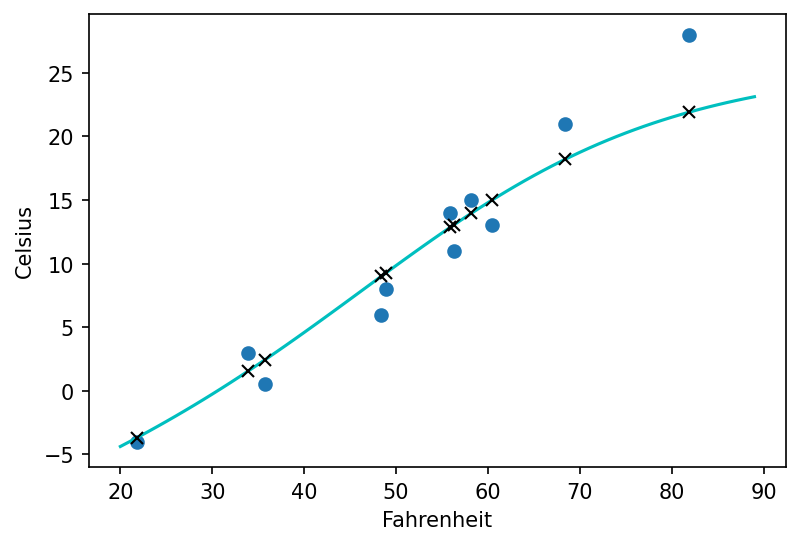

In [25]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
